### IMPORTING NECESSARY LIBRARIES 


In [66]:
import re
import regex
import pandas as pd
import numpy as np
from datetime import datetime
import time
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import plotly.express as px
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### CLEANING WHATSAPP CHAT TEXT FILE 

In [67]:
def starts_with_date_and_time(s):
    
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9][0-9])'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [68]:
def has_author(s):
    
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [69]:
def get_data_point(line):   
    
    split_line = line.split(' - ') 
    date_time = split_line[0]
    date, time = date_time.split(', ') 
    message = ' - '.join(split_line[1:])
    if has_author(message): 
        split_message = message.split(':') 
        author = split_message[0] 
        message = ':'.join(split_message[1:])
    else:
        author = None
    return date_time, date, time, author, message

In [70]:
parsed_data = [] # List to keep track of data so it can be used by a Pandas dataframe
conversation_path = "C:\\Users\\HP\\Desktop\\whatsapp\\kand.txt"
with open(conversation_path, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    message_buffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if starts_with_date_and_time(line): 
            if len(message_buffer) > 0: 
                parsed_data.append([date_time, date, time, author, (' '.join(message_buffer)).strip()]) 
            message_buffer.clear() 
            date_time, date, time, author, message = get_data_point(line) 
            message_buffer.append(message) 
        else:
            message_buffer.append(line)

### DATAFRAME 

In [71]:
df = pd.DataFrame(parsed_data, columns=['Date_Time', 'Date', 'Time', 'Author', 'Message'])
df.head()

,Date_Time,Date,Time,Author,Message
0,"18/04/19, 11:24 pm",18/04/19,11:24 pm,None,"You created group ""🎉"""
1,"18/04/19, 11:24 pm",18/04/19,11:24 pm,Arpan DC,Kal shaam 7 baje.
2,"18/04/19, 11:28 pm",18/04/19,11:28 pm,Shivam MECH,Kya?
3,"18/04/19, 11:28 pm",18/04/19,11:28 pm,Arpan DC,Jums
4,"18/04/19, 11:29 pm",18/04/19,11:29 pm,Shivam MECH,Ok


In [72]:
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date_Time,Date,Time,Author,Message
0,"18/04/19, 11:24 pm",2019-04-18,11:24 pm,None,"You created group ""🎉"""
1,"18/04/19, 11:24 pm",2019-04-18,11:24 pm,Arpan DC,Kal shaam 7 baje.
2,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Shivam MECH,Kya?
3,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Arpan DC,Jums
4,"18/04/19, 11:29 pm",2019-04-18,11:29 pm,Shivam MECH,Ok


### MISSING VALUES

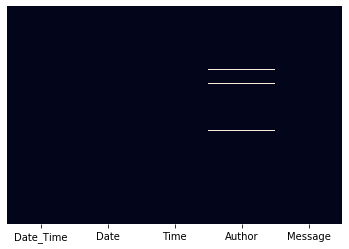

In [73]:
import seaborn as sns
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)

In [74]:
df.isnull().sum()

Date_Time     0
Date          0
Time          0
Author       16
Message       0
dtype: int64

In [75]:
df=df.dropna()
a=df['Author'].unique()
authors=list(a)
authors

['Arpan DC', 'Shivam MECH', 'Nilanjan Mech', 'Debjyoti Mech']

In [76]:
df=df[(df.Message != '<Media omitted>')]    ### REMOVING ROWS WITH MEDIA SINCE MEDIA FROM THE CHAT IS NOT EXPORTED
df.head()

,Date_Time,Date,Time,Author,Message
1,"18/04/19, 11:24 pm",2019-04-18,11:24 pm,Arpan DC,Kal shaam 7 baje.
2,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Shivam MECH,Kya?
3,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Arpan DC,Jums
4,"18/04/19, 11:29 pm",2019-04-18,11:29 pm,Shivam MECH,Ok
5,"18/04/19, 11:33 pm",2019-04-18,11:33 pm,Nilanjan Mech,Maane ??


### EXPLORATORY DATA ANALYSIS

In [77]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
data=[]
for word in df.Message:
    token=nltk.word_tokenize(str(word).lower())
    data.extend(token)

In [79]:
word_list=nltk.FreqDist(data)
word_list['ok']

61

In [80]:
word_list.most_common(100)

[('?', 736),
 ('hai', 409),
 ('toh', 216),
 ('...', 193),
 (':', 169),
 ('he', 153),
 ('na', 145),
 ('ka', 144),
 ('nahi', 142),
 ('tha', 136),
 ('kya', 129),
 ('ha', 114),
 ('ke', 110),
 ('@', 109),
 ('kar', 108),
 ('bhi', 107),
 ('raha', 102),
 ('https', 99),
 ('bhai', 99),
 ('me', 99),
 (',', 98),
 ('.', 96),
 ('hi', 94),
 ('main', 88),
 ('yeh', 86),
 ('se', 81),
 ('ki', 80),
 ('the', 77),
 ('e', 76),
 ('😂', 75),
 ('hoga', 74),
 ('er', 72),
 ('!', 66),
 ('ho', 65),
 ('ko', 65),
 ('ta', 63),
 ('&', 63),
 ('ok', 61),
 ('gaya', 61),
 ('dekh', 59),
 ('aur', 58),
 ('wala', 58),
 ('kal', 57),
 ('koi', 57),
 ('🤣', 57),
 ('haa', 57),
 ('this', 55),
 ('bol', 55),
 ('class', 54),
 ('abhi', 54),
 ('sab', 53),
 ('haan', 51),
 ('😂😂😂', 50),
 ('tu', 47),
 ('hu', 47),
 ('aaj', 46),
 ('message', 46),
 ('woh', 46),
 ('http', 44),
 ('to', 43),
 ('deleted', 43),
 ('ek', 43),
 ('was', 42),
 ('kiya', 42),
 ('ye', 41),
 ('ache', 40),
 ('bola', 39),
 ('diya', 39),
 ('😅', 39),
 ('hua', 39),
 ('of', 38),
 ('

In [81]:
import regex
def emojii(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list
    
 
df["Emoji"] = df["Message"].apply(emojii)
emojis = sum(df["Emoji"].str.len())
df["Emoji_Count"] = df["Emoji"].str.len()
df["Line_Count"]=1

In [82]:
print("Chat Stats")
print("Messages: ", df.shape[0])
print("Emojis: ", emojis)


Chat Stats
Messages:  3614
Emojis:  1413


In [83]:
messages_df = df
messages_df['Word_Count'] = messages_df['Message'].str.split().str.len()
messages_df.head()

,Date_Time,Date,Time,Author,Message,Emoji,Emoji_Count,Line_Count,Word_Count
1,"18/04/19, 11:24 pm",2019-04-18,11:24 pm,Arpan DC,Kal shaam 7 baje.,[],0,1,4
2,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Shivam MECH,Kya?,[],0,1,1
3,"18/04/19, 11:28 pm",2019-04-18,11:28 pm,Arpan DC,Jums,[],0,1,1
4,"18/04/19, 11:29 pm",2019-04-18,11:29 pm,Shivam MECH,Ok,[],0,1,1
5,"18/04/19, 11:33 pm",2019-04-18,11:33 pm,Nilanjan Mech,Maane ??,[],0,1,2


### MESSAGES SENT - PERCENTAGE 

In [84]:
import plotly.express as px
fig = px.pie(messages_df, values='Line_Count', names='Author', title='Messages sent')
fig.show()

In [85]:
fig = px.pie(messages_df, values='Word_Count', names='Author', title='Words sent')
fig.show()

### EMOJIS SENT- PERCENTAGE

In [86]:
fig = px.pie(messages_df, values='Emoji_Count', names='Author', title='Emojis sent')
fig.show()


In [87]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
from wordcloud import WordCloud


### MOST COMMON WORDS

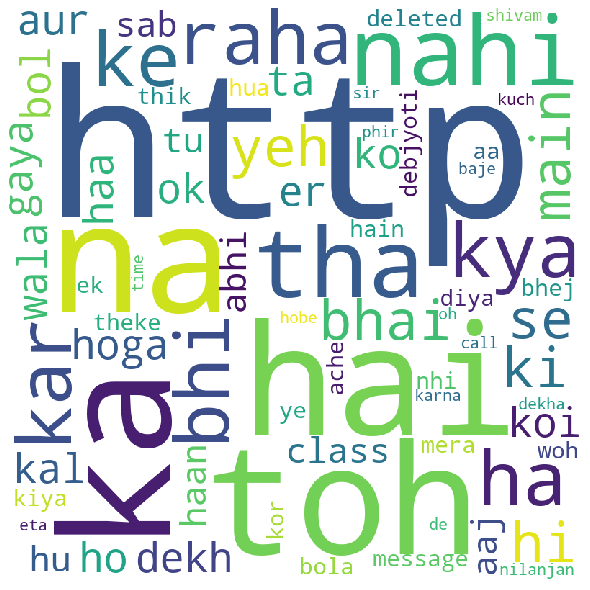

In [89]:
words_for_wordcloud = ' '.join([w[0] for w in word_list.most_common(100)])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords=stopwords,min_font_size = 10).generate(words_for_wordcloud) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


### MESSAGE SENT/ USER

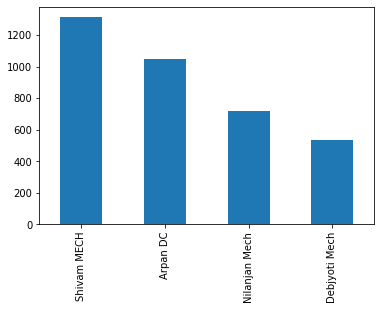

In [90]:
df['Author'].value_counts().plot(kind='bar')

### EMOJIS DISTRIBUTION / USER

In [91]:
MINIMUM_THRESHOLD = 40
from collections import Counter

for author in authors:
    df_1 = messages_df[messages_df['Author']==author]
    total_emojis_list = list([a for emoji_list in df_1.Emoji for a in emoji_list])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    
    print('Emoji Distribution for ' + author + ':\n')
    
    author_emoji_df = pd.DataFrame(emoji_dict, columns=['Emoji', 'Count'])
    author_emoji_df.loc[author_emoji_df['Count'] <= MINIMUM_THRESHOLD, 'Emoji'] = 'others'
    
    fig = px.pie(author_emoji_df, values='Count', names='Emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for Arpan DC:



Emoji Distribution for Shivam MECH:



Emoji Distribution for Nilanjan Mech:



Emoji Distribution for Debjyoti Mech:



### WORD DISTRIBUTION / USER

WordCloud for Arpan DC:



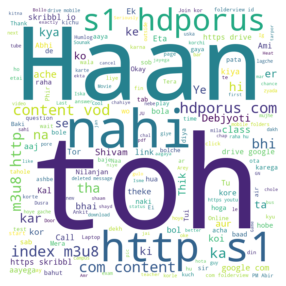


WordCloud for Shivam MECH:



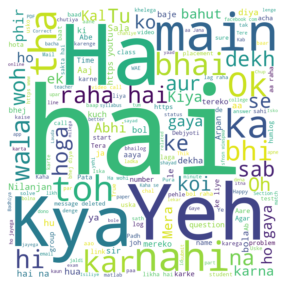


WordCloud for Nilanjan Mech:



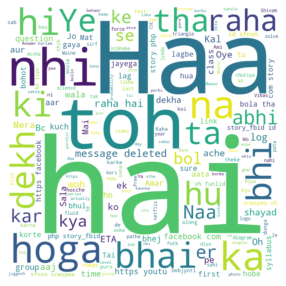


WordCloud for Debjyoti Mech:



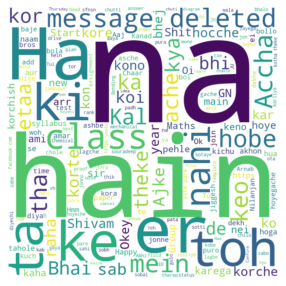

In [92]:
from nltk.tokenize import word_tokenize
for author in authors:
    selected_df = messages_df[messages_df['Author']==author]
    text = " ".join(word_ for word_ in selected_df.Message)
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word.lower() in stopwords]
    sentence = (" ").join(tokens_without_sw)
    
    print("WordCloud for " + author + ":\n")
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords=stopwords,min_font_size = 10).generate(sentence)
    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print()

### EMOJI DISTRIBUTION - MONTH OVER MONTH

In [93]:
cols = ['Year', 'Month', 'Emoji', 'Count']
row_list = []

messages_df = df

messages_df['Month'] = messages_df.Date.dt.to_period("M")
messages_df['Month'] = messages_df['Month'].dt.strftime('%Y-%m')

months = messages_df['Month'].unique()

for month in months:
    selected_df = messages_df[messages_df['Month']==month]
    total_emojis_list = list([a for emoji_list in selected_df.Emoji for a in emoji_list])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    emoji_dict = emoji_dict[:3]
    year = month.split("-")[0]
    for emoji in emoji_dict:
        row_list.append([year, month, emoji[0], emoji[1]])
        
emoji_distribution = pd.DataFrame(row_list, columns=cols)
emoji_distribution.head()

,Year,Month,Emoji,Count
0,2019,2019-04,😂,8
1,2019,2019-04,🤣,7
2,2019,2019-04,😆,4
3,2019,2019-10,🤣,33
4,2019,2019-10,😂,20


In [94]:
fig=px.sunburst(emoji_distribution,path=['Year','Month','Emoji'],values='Count',title='Emoji Distribution Month Over Month')
fig.show()

### CHAT DISTRIBUTION MONTH OVER MONTH

In [95]:
per_month = messages_df.Date.dt.to_period("M")
month_df = messages_df.groupby(per_month).sum()

month_df.reset_index(level=0, inplace=True)
month_df['Date'] = month_df['Date'].dt.strftime('%Y-%m')

month_df = month_df.melt(id_vars=["Date"], var_name="Count", value_name="Value")

In [96]:
fig = px.scatter(month_df, x="Date", y="Value", color='Count',
                 title='Chat Distribution: Monthly').update_traces(mode='lines+markers')
fig.show()

### CHAT DISTRIBUTION - DAY WISE

In [97]:
def day_of_week(i):
    
    day_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return day_list[i];

day_df=pd.DataFrame(messages_df["Message"])
day_df['Day'] = messages_df['Date'].dt.weekday
day_df.sort_values(by=['Day'], inplace=True)
day_df['Day'] = day_df["Day"].apply(day_of_week)
day_df["Line_Count"] = 1
day_df = day_df.groupby("Day", sort=False).sum()
day_df.reset_index(inplace=True)
day_df.head()

,Day,Line_Count
0,Monday,472
1,Tuesday,604
2,Wednesday,678
3,Thursday,430
4,Friday,465


In [98]:
fig = px.line_polar(day_df, r='Line_Count', theta='Day', line_close=True, title="Chat Distribution: Daily")
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,6000]
    )),
  showlegend=False
)
fig.show()


### DATE-WISE


Text(0, 0.5, 'Date')

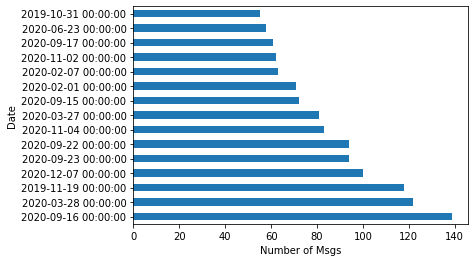

In [99]:
df['Date'].value_counts().head(15).plot.barh()
plt.xlabel('Number of Msgs')
plt.ylabel("Date")

### TIME-WISE

Text(0, 0.5, 'Time')

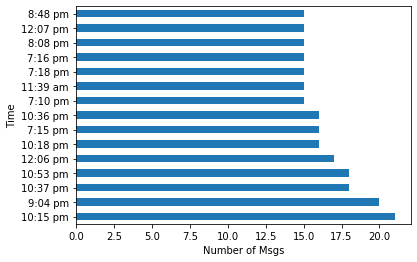

In [100]:
df['Time'].value_counts().head(15).plot.barh()
plt.xlabel('Number of Msgs')
plt.ylabel("Time")